## Implementación de un recomendador de aperturas usando redes neuronales

# Instalación de dependencias

In [1]:
!pip install tensorflow imbalanced-learn joblib python-chess chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=1e7f5440ddc0f7724d3a1f1394983738c13a1f24dc1f021eba246e88223e76ab
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


# Importación de librerías

In [2]:
import chess.pgn
import io
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files
import chardet
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict, Counter

# Clase principal del recomendador

In [ ]:
class OpeningRecommender:
    def __init__(self):

        self.opening_mapping = {
            'Catalana': {'style': 'posicional'},
            'Inglesa': {'style': 'posicional'},
            'Londres': {'style': 'posicional'},
            'Escocesa': {'style': 'combinativo'},
            'Gambito_de_Rey': {'style': 'combinativo'},
            'Gambito_Danes': {'style': 'combinativo'},
            'Italiana': {'style': 'universal'},
            'Española': {'style': 'universal'},
            'Gambito_de_Dama': {'style': 'universal'}
        }

        self.style_spanish_mapping = {
            'positional': 'posicional',
            'combinative': 'combinativo',
            'universal': 'universal'
        }

        self.scaler = StandardScaler()
        self.opening_encoder = LabelEncoder()
        self.style_encoder = LabelEncoder()

        opening_names = list(self.opening_mapping.keys())
        self.opening_encoder.fit(opening_names)

        styles = list({v['style'] for v in self.opening_mapping.values()})
        self.style_encoder.fit(styles)

        self.model = None

    def _build_recommendation_model(self, input_shape, num_openings):
        """Construye la red neuronal para recomendación de aperturas"""
        model = Sequential([
            Dense(256, activation='relu', input_shape=(input_shape,)),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(num_openings, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.0008),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def process_pgns(self):
        """Procesa archivos PGN usando el nombre del archivo como fuente de la apertura"""
        features = []
        opening_labels = []
        styles = []
        uploaded = files.upload()

        for filename, content in uploaded.items():
            try:
                opening_name = os.path.splitext(filename)[0].replace(' ', '_')
                if opening_name not in self.opening_mapping:
                    print(f"[!] Archivo {filename} no corresponde a apertura conocida")
                    continue

                print(f"Se esta analizando las partidas de la apertura {filename}")

                # Obtener estilo asociado a la apertura
                opening_style = self.opening_mapping[opening_name]['style']

                # Detectar codificación
                enc = chardet.detect(content)['encoding'] or 'latin-1'
                pgn_text = content.decode(enc, errors='replace')
                pgn = io.StringIO(pgn_text)

                while True:
                    game = chess.pgn.read_game(pgn)
                    if not game:
                        break

                    # Extraer características técnicas y de estilo
                    game_features = self._extract_game_features(game, opening_style)
                    if game_features:
                        features.append(game_features)
                        opening_labels.append(opening_name)
                        styles.append(opening_style)

                print(f"Se terminó de analizar las partidas de la apertura {filename}")

            except Exception as e:
                print(f"Error procesando {filename}: {str(e)}")
                continue

        if not features:
            print("No hay datos válidos para entrenar")
            return False

        # Preprocesamiento
        print("Inicio el preprocesamiento")
        self.X = np.array(features)
        self.y = self.opening_encoder.transform(opening_labels)
        self.y_onehot = to_categorical(self.y)

        # Escalar características
        print("Inicio el escalamiento")
        self.scaler.fit(self.X)
        self.X = self.scaler.transform(self.X)

        # Balancear datos
        print("Inicio el balanceo de datos")
        adasyn = ADASYN(n_neighbors=2)
        self.X, self.y = adasyn.fit_resample(self.X, self.y)
        self.y_onehot = to_categorical(self.y)

        print(f"\nDatos procesados: {len(self.X)} partidas")
        print("Distribución de aperturas:", dict(zip(
            self.opening_encoder.inverse_transform(np.unique(self.y)),
            np.bincount(self.y)
        )))

        # Construir modelo
        self.model = self._build_recommendation_model(
            self.X.shape[1],
            len(self.opening_encoder.classes_)
        )
        return True

    def _extract_game_features(self, game, style, color=chess.WHITE):
        """Extrae características avanzadas de una partida de ajedrez con estilo"""
        MOVES_TO_ANALYZE = 30
        FEATURES_PER_MOVE = 13
        STYLE_FEATURES = len(self.style_encoder.classes_)
        TOTAL_FEATURES = MOVES_TO_ANALYZE * FEATURES_PER_MOVE + STYLE_FEATURES

        board = game.board()
        features = []
        previous_material = 0
        moves_analyzed = 0

        try:
            for i, move in enumerate(game.mainline_moves()):
                board.push(move)
                if board.turn != color:
                    continue

                if moves_analyzed < MOVES_TO_ANALYZE:
                    move_features = [
                        self._calculate_material_balance(board),
                        self._king_safety_score(board),
                        self._pawn_structure_analysis(board),
                        self._piece_activity_score(board),
                        self._control_of_key_squares(board),
                        self._openness_position(board),
                        self._sacrifice_detection(board, move, previous_material),
                        self._tactical_opportunities(board),
                        self._space_advantage(board),
                        self._piece_mobility(board),
                        self._passed_pawns_count(board),
                        self._bishop_pair_advantage(board),
                        self._pieces_in_enemy_territory(board)
                    ]
                    features.extend(move_features)
                    previous_material = self._calculate_total_material(board)
                    moves_analyzed += 1

                if len(features) >= MOVES_TO_ANALYZE * FEATURES_PER_MOVE:
                    break

            # Agregar características de estilo
            style_encoded = self.style_encoder.transform([style])[0]
            style_onehot = [0] * STYLE_FEATURES
            style_onehot[style_encoded] = 1
            features += style_onehot

            # Asegurar longitud fija
            current_length = len(features)
            if current_length < TOTAL_FEATURES:
                features += [0] * (TOTAL_FEATURES - current_length)
            return features[:TOTAL_FEATURES]

        except Exception as e:
            print(f"Error en extracción: {str(e)}")
            return None

    def _calculate_material_balance(self, board):
        """Balance material con valores de pieza ajustados"""
        piece_values = {
            chess.PAWN: 1.5,    # Valor ligeramente mayor por estructura
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,  # Par de alfiles bonus se maneja aparte
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        white = sum(len(board.pieces(pt, chess.WHITE)) * val for pt, val in piece_values.items())
        black = sum(len(board.pieces(pt, chess.BLACK)) * val for pt, val in piece_values.items())
        return (white - black) / 10  # Sin la division por 10, la maxima diferencia es de +-45.4

    def _king_safety_score(self, board):
        """Evaluación detallada de la seguridad del rey"""
        king_square = board.king(board.turn)
        if not king_square:
            return 0

        # Escudo de peones
        pawn_shield = sum(1 for sq in board.attacks(king_square)
              if board.piece_type_at(sq) == chess.PAWN
              and board.color_at(sq) == board.turn)

        # Ataques potenciales
        attackers = len(board.attackers(not board.turn, king_square))

        # Posición del rey (centro vs esquina)
        file = chess.square_file(king_square)
        rank = chess.square_rank(king_square)
        center_distance = abs(3.5 - file) + abs(3.5 - rank)

        return (pawn_shield * 0.5) - (attackers * 0.3) - (center_distance * 0.2) # Entre -2 y +3

    def _piece_mobility(self, board):
        """Movilidad de las piezas (número de movimientos legales disponibles)"""
        mobility = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                mobility += len(board.attacks(sq))
        return mobility / 50

    def _is_passed_pawn(self, board, pawn_square):
        """Verifica si un peón es pasado"""
        color = board.color_at(pawn_square)
        if color is None:
            return False

        pawn_file = chess.square_file(pawn_square)
        pawn_rank = chess.square_rank(pawn_square)

        # Determinar dirección según color
        direction = 1 if color == chess.WHITE else -1
        start_rank = pawn_rank + direction

        # Verificar casillas hacia adelante en columnas adyacentes
        for rank in range(start_rank, 8) if color == chess.WHITE else range(start_rank, -1, -1):
            for file_offset in (-1, 0, 1):
                current_file = pawn_file + file_offset
                if 0 <= current_file <= 7:
                    square = chess.square(current_file, rank)
                    # Verificar peones enemigos
                    if board.piece_type_at(square) == chess.PAWN and board.color_at(square) != color:
                        return False
        return True

    def _passed_pawns_count(self, board):
        """Conteo de peones pasados"""
        passed = 0
        pawns = board.pieces(chess.PAWN, board.turn)
        enemy_pawns = board.pieces(chess.PAWN, not board.turn)
        for pawn in pawns:
            is_passed = True
            pawn_file = chess.square_file(pawn)
            pawn_rank = chess.square_rank(pawn)
            # Verificar columnas adyacentes y frente del peón
            for file in [pawn_file-1, pawn_file, pawn_file+1]:
                if 0 <= file <= 7:
                    for rank in range(pawn_rank+1, 8):
                        if chess.square(file, rank) in enemy_pawns:
                            is_passed = False
                            break
                    if not is_passed:
                        break
            if is_passed:
                passed += 1
        return passed / 8

    def _pawn_structure_analysis(self, board):
        """Análisis completo de estructura de peones"""
        pawns = board.pieces(chess.PAWN, board.turn)
        score = 0

        # Peones doblados
        files = [chess.square_file(p) for p in pawns]
        score -= sum(v-1 for v in Counter(files).values())

        # Peones pasados
        score += sum(1 for p in pawns if self._is_passed_pawn(board, p))

        # Peones aislados
        adjacent_files = set()
        for f in files:
            adjacent_files.update([f-1, f+1])
        score -= sum(1 for f in files if f not in adjacent_files)

        return score

    def _piece_activity_score(self, board):
        """Movilidad y actividad de piezas mayores"""
        activity = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                activity += len(board.attacks(sq))
        return activity / 20

    def _control_of_key_squares(self, board):
        """Control de centros estratégicos y casillas clave"""
        key_squares = [
            chess.D4, chess.D5, chess.E4, chess.E5,  # Centro clásico
            chess.C3, chess.C6, chess.F3, chess.F6,  # Centro extendido
            chess.D3, chess.E3, chess.D6, chess.E6  # Acceso al centro
        ]
        return sum(1 for sq in key_squares if board.is_attacked_by(board.turn, sq))

    def _openness_position(self, board):
        """Evalúa si la posición es abierta o cerrada"""
        open_files = 0
        for file in range(8):
            # Verificar si hay peones en el archivo para ambos colores
            has_pawns = False
            for color in [chess.WHITE, chess.BLACK]:
                for sq in board.pieces(chess.PAWN, color):
                    if chess.square_file(sq) == file:
                        has_pawns = True
                        break
                if has_pawns:
                    break
            if not has_pawns:
                open_files += 1
        return open_files

    def _calculate_total_material(self, board):
        """Calcula el material total del jugador actual"""
        piece_values = {
            chess.PAWN: 1.5,
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        total = 0
        for piece_type, value in piece_values.items():
            total += len(board.pieces(piece_type, board.turn)) * value
        return total

    def _sacrifice_detection(self, board, move, previous_material):
        """Detección de sacrificios posicionales y materiales"""
        current_material = self._calculate_total_material(board)
        material_diff = previous_material - current_material

        # Sacrificio si pérdida material > 2 puntos y control del centro aumenta
        if material_diff > 2 and self._control_of_key_squares(board) > 4:
            return 1
        return 0

    def _tactical_opportunities(self, board):
        """Oportunidades tácticas potenciales"""
        hanging_pieces = 0
        for color in [chess.WHITE, chess.BLACK]:
            for sq in board.pieces(chess.PAWN, color):
                if not board.attackers(color, sq):
                    hanging_pieces += 1
        return -hanging_pieces if board.turn == chess.WHITE else hanging_pieces

    def _space_advantage(self, board):
        """Ventaja espacial en el tablero"""
        squares_controlled = 0
        for sq in chess.SQUARES:
            if board.is_attacked_by(board.turn, sq):
                squares_controlled += 1
        return squares_controlled / 64

    def _bishop_pair_advantage(self, board):
        """Ventaja de pareja de alfiles"""
        white_bishops = len(board.pieces(chess.BISHOP, chess.WHITE))
        black_bishops = len(board.pieces(chess.BISHOP, chess.BLACK))

        white_pair = 1 if white_bishops >= 2 else 0
        black_pair = 1 if black_bishops >= 2 else 0
        return white_pair - black_pair

    def _pieces_in_enemy_territory(self, board):
        """Calcula cuántas piezas están en campo enemigo"""
        enemy_territory = range(24, 64) if board.turn == chess.WHITE else range(0, 40)
        count = 0
        for square in chess.SQUARES:
            if square in enemy_territory and board.piece_at(square) and board.color_at(square) == board.turn:
                # Dar mayor peso a piezas de ataque
                piece_type = board.piece_type_at(square)
                if piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                    count += 1.5
                else:
                    count += 1
        return count / 10

    def train_model(self):
        """Entrena el modelo"""
        if not hasattr(self, 'X') or not hasattr(self, 'y_onehot'):
            print("Primero debe procesar datos con process_pgns()")
            return
        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            self.y_onehot,
            test_size=0.2,
            random_state=42
        )
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.0001
        )
        history = self.model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluación final
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        y_pred = self.model.predict(X_test)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f"\nPrecisión final en test: {accuracy*100:.2f}%")
        self._plot_training_history(history, conf_matrix)

    def recommend_for_pgn(self, pgn_text, color, player_style=None):
        """Recomienda aperturas basadas en un PGN de partida y estilo de jugador"""

        try:
            if player_style and player_style not in self.style_spanish_mapping.values():
                return f"Estilo '{player_style}' no válido. Opciones: {list(self.style_spanish_mapping.values())}"

            # Procesar PGN
            pgn = io.StringIO(pgn_text)
            game = chess.pgn.read_game(pgn)
            if not game:
                return "Error: No se pudo leer el PGN"

            chess_color = chess.WHITE if color.lower() == 'white' else chess.BLACK

            features = self._extract_game_features(game, player_style, chess_color)
            if not features:
                return "Error: No se pudieron extraer características"

            scaled_features = self.scaler.transform([features])

            prediction = self.model.predict(scaled_features, verbose=0)[0]

            opening_names = list(self.opening_mapping.keys())
            recommendations = []
            for idx, prob in enumerate(prediction):
                opening = opening_names[idx]
                if opening not in self.opening_mapping:
                    continue
                recommendations.append({
                    'apertura': opening,
                    'estilo': self.opening_mapping[opening]['style'],
                    'probabilidad': float(prob),
                    'ponderacion' : 0.00
                })

            recommendations.sort(key=lambda x: (-x['probabilidad'], x['apertura']))
            return recommendations[:3]

        except Exception as e:
            return f"Error: {str(e)}"

    def save_model(self, filename="opening_recommender"):
        """Guarda el modelo y metadatos"""
        model_data = {
            'scaler': self.scaler,
            'opening_encoder': self.opening_encoder,
            'style_encoder': self.style_encoder,
            'opening_mapping': self.opening_mapping,
            'style_spanish_mapping': self.style_spanish_mapping
        }

        self.model.save(f"{filename}.keras")

        joblib.dump(model_data, f"{filename}_metadata.joblib")
        print(f"Modelo guardado como {filename}.keras")

    @classmethod
    def load_model(cls, filename="opening_recommender"):
        """Carga el modelo y metadatos"""
        recommender = cls()

        # Cargar metadatos
        model_data = joblib.load(f"{filename}_metadata.joblib")
        recommender.scaler = model_data['scaler']
        recommender.opening_encoder = model_data['opening_encoder']
        recommender.style_encoder = model_data['style_encoder']
        recommender.opening_mapping = model_data['opening_mapping']
        recommender.style_spanish_mapping = model_data['style_spanish_mapping']

        # Cargar modelo
        recommender.model = load_model(f"{filename}.keras")
        print(f"Modelo cargado desde {filename}.keras")
        return recommender

    def _plot_training_history(self, history, conf_matrix):
        """Genera gráficos de entrenamiento"""
        plt.figure(figsize=(18, 6))

        # Precisión
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Entrenamiento')
        plt.plot(history.history['val_accuracy'], label='Validación')
        plt.title('Evolución de Precisión')
        plt.ylabel('Precisión')
        plt.xlabel('Época')
        plt.legend()

        # Pérdida
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Entrenamiento')
        plt.plot(history.history['val_loss'], label='Validación')
        plt.title('Evolución de Pérdida')
        plt.ylabel('Pérdida')
        plt.xlabel('Época')
        plt.legend()

        # Matriz de confusión
        plt.subplot(1, 3, 3)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.opening_encoder.classes_,
                    yticklabels=self.opening_encoder.classes_)
        plt.title('Matriz de Confusión')
        plt.ylabel('Verdadero')
        plt.xlabel('Predicho')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.show()

# Flujo de ejecución completo

Saving Catalana.pgn to Catalana.pgn
Saving Escocesa.pgn to Escocesa.pgn
Saving Española.pgn to Española.pgn
Saving Gambito_Danes.pgn to Gambito_Danes.pgn
Saving Gambito_de_Dama.pgn to Gambito_de_Dama.pgn
Saving Gambito_de_Rey.pgn to Gambito_de_Rey.pgn
Saving Inglesa.pgn to Inglesa.pgn
Saving Italiana.pgn to Italiana.pgn
Saving Londres.pgn to Londres.pgn
Se esta analizando las partidas de la apertura Catalana.pgn
Se terminó de analizar las partidas de la apertura Catalana.pgn
Se esta analizando las partidas de la apertura Escocesa.pgn
Se terminó de analizar las partidas de la apertura Escocesa.pgn
Se esta analizando las partidas de la apertura Española.pgn
Se terminó de analizar las partidas de la apertura Española.pgn
Se esta analizando las partidas de la apertura Gambito_Danes.pgn
Se terminó de analizar las partidas de la apertura Gambito_Danes.pgn
Se esta analizando las partidas de la apertura Gambito_de_Dama.pgn
Se terminó de analizar las partidas de la apertura Gambito_de_Dama.pgn


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.9294 - loss: 0.2162 - val_accuracy: 0.9967 - val_loss: 0.0119
Epoch 2/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9942 - loss: 0.0197 - val_accuracy: 0.9975 - val_loss: 0.0075
Epoch 3/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.9956 - loss: 0.0144 - val_accuracy: 0.9979 - val_loss: 0.0064
Epoch 4/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.9960 - loss: 0.0120 - val_accuracy: 0.9982 - val_loss: 0.0063
Epoch 5/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.9966 - loss: 0.0103 - val_accuracy: 0.9979 - val_loss: 0.0058
Epoch 6/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9972 - val_loss: 0.0076
Epoch 7/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9969 - loss: 0.0091 - val_accuracy: 0.9980 - val_loss: 0.0057
Epoch 8/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9970 - loss: 0

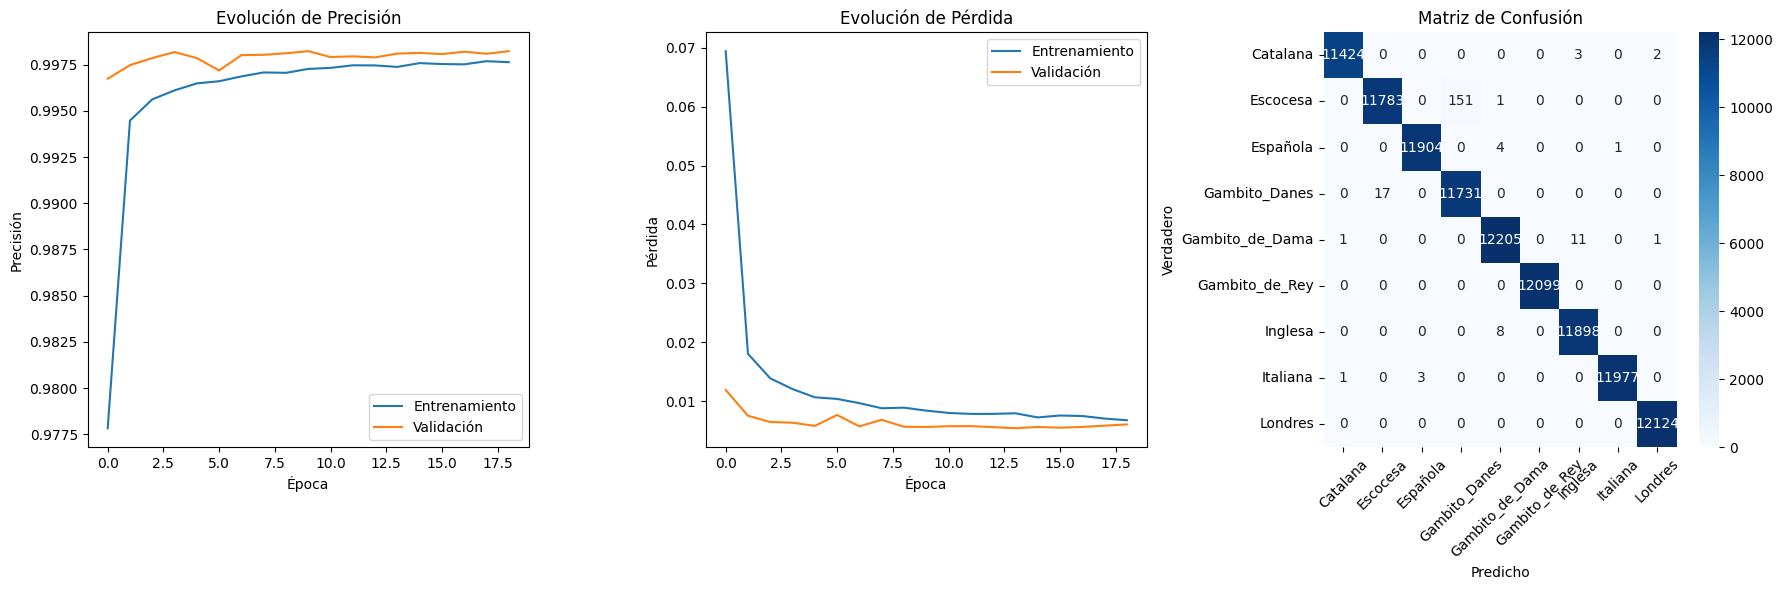

Modelo guardado como opening_recommender_model.keras


In [4]:
recommender = OpeningRecommender()
if recommender.process_pgns():
  recommender.train_model()
  recommender.save_model("opening_recommender_model")

In [5]:
model = OpeningRecommender.load_model("opening_recommender_model")

pgn = """
[Event "rated blitz game"]
[Site "https://lichess.org/AtwDAwKW"]
[Date "2025.06.12"]
[White "fredgra2"]
[Black "captain_quesillo"]
[Result "1-0"]
[GameId "AtwDAwKW"]
[UTCDate "2025.06.12"]
[UTCTime "05:09:38"]
[WhiteElo "2182"]
[BlackElo "2035"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[WhiteTitle "CM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Opening "Sicilian Defense: Smith-Morra Gambit Accepted"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. e4 { [%eval 0.18] [%clk 0:03:00] } 1... c5 { [%eval 0.25] [%clk 0:03:00] } 2. d4 { [%eval 0.05] [%clk 0:02:59] } 2... cxd4 { [%eval 0.02] [%clk 0:02:59] } 3. c3 { [%eval -0.09] [%clk 0:02:59] } 3... dxc3 { [%eval -0.12] [%clk 0:02:58] } { B21 Sicilian Defense: Smith-Morra Gambit Accepted } 4. Nxc3 { [%eval -0.22] [%clk 0:02:59] } 4... g6 { [%eval 0.0] [%clk 0:02:57] } 5. Nf3 { [%eval 0.0] [%clk 0:02:58] } 5... Bg7 { [%eval 0.0] [%clk 0:02:56] } 6. h4 { [%eval -0.5] [%clk 0:02:58] } 6... a6? { (-0.50 → 0.80) Mistake. Nf6 was best. } { [%eval 0.8] [%clk 0:02:56] } (6... Nf6 7. Qa4 Ng4 8. h5 Qb6 9. Qc2 Nc6 10. h6 Bf6 11. Qd2) 7. h5 { [%eval 1.04] [%clk 0:02:56] } 7... e6 { [%eval 1.36] [%clk 0:02:48] } 8. Bg5 { [%eval 1.06] [%clk 0:02:50] } 8... Qa5 { [%eval 1.34] [%clk 0:02:43] } 9. h6 { [%eval 1.36] [%clk 0:02:41] } 9... Bxc3+ { [%eval 1.29] [%clk 0:02:38] } 10. bxc3 { [%eval 1.32] [%clk 0:02:39] } 10... Qxc3+ { [%eval 1.57] [%clk 0:02:37] } 11. Bd2 { [%eval 1.67] [%clk 0:02:38] } 11... Qc6 { [%eval 2.22] [%clk 0:02:33] } 12. Rc1?! { (2.22 → 1.09) Inaccuracy. Be2 was best. } { [%eval 1.09] [%clk 0:02:35] } (12. Be2 Qd6 13. e5 Qf8 14. Ng5 f5 15. exf6 Nxf6 16. Rc1 Nc6 17. O-O d5) 12... Qxe4+ { [%eval 1.36] [%clk 0:02:32] } 13. Be2 { [%eval 0.51] [%clk 0:02:28] } 13... Ne7?? { (0.51 → 2.74) Blunder. Nc6 was best. } { [%eval 2.74] [%clk 0:02:31] } (13... Nc6 14. Bc3 f6 15. Rh4 Qd5 16. Nd2 Qd6 17. a4 b5 18. Bf3 Nge7 19. Bxf6) 14. Rh4 { [%eval 3.04] [%clk 0:02:18] } 14... Qf5 { [%eval 2.86] [%clk 0:02:21] } 15. Nd4?? { (2.86 → 0.15) Blunder. Rd4 was best. } { [%eval 0.15] [%clk 0:01:35] } (15. Rd4 e5 16. g4 Qe6 17. Ng5 exd4 18. Nxe6 fxe6 19. Bb4 Nbc6 20. Bd6 b5) 15... Qf6? { (0.15 → 1.53) Mistake. Qd5 was best. } { [%eval 1.53] [%clk 0:02:17] } (15... Qd5 16. Bf3) 16. Nf3 { [%eval 1.56] [%clk 0:01:29] } 16... O-O?? { (1.56 → 4.72) Blunder. Nbc6 was best. } { [%eval 4.72] [%clk 0:02:15] } (16... Nbc6 17. Rf4 Nf5 18. g4 e5 19. gxf5 gxf5 20. Rh4 Rg8 21. Rh5 d5 22. Qb3) 17. Bc3? { (4.72 → 2.93) Mistake. Bg5 was best. } { [%eval 2.93] [%clk 0:01:13] } (17. Bg5 Qh8 18. Bxe7 Re8 19. Rf4 f5 20. Bb4 Nc6 21. Bc3 e5 22. Ng5 Qf6) 17... Qf5 { [%eval 1.2] [%clk 0:02:12] } 18. Bd3 { [%eval 0.81] [%clk 0:01:01] } 18... Qd5 { [%eval 0.66] [%clk 0:02:00] } 19. Rd4 { [%eval 0.67] [%clk 0:00:57] } 19... Qh5 { [%eval 0.86] [%clk 0:01:56] } 20. Rh4 { [%eval 0.92] [%clk 0:00:51] } 20... Qd5 { [%eval 0.82] [%clk 0:01:54] } 21. Bg7 { [%eval 0.59] [%clk 0:00:41] } 21... Nf5?? { (0.59 → 4.54) Blunder. Re8 was best. } { [%eval 4.54] [%clk 0:01:42] } (21... Re8 22. Qd2) 22. Bxf5 { [%eval 4.08] [%clk 0:00:32] } 22... Qxd1+ { [%eval 4.02] [%clk 0:01:40] } 23. Kxd1 { [%eval 3.99] [%clk 0:00:31] } 23... exf5?! { (3.99 → 5.01) Inaccuracy. Re8 was best. } { [%eval 5.01] [%clk 0:01:38] } (23... Re8 24. Bc2 Nc6 25. Kd2 b5 26. Ng5 f5 27. g4 Na5 28. gxf5 exf5 29. Bb3+) 24. Bxf8 { [%eval 4.97] [%clk 0:00:30] } 24... Kxf8?! { (4.97 → 7.99) Inaccuracy. Nc6 was best. } { [%eval 7.99] [%clk 0:01:37] } (24... Nc6 25. Bg7 b5 26. Bf6 Bb7 27. Ng5 Na5 28. Rc7 Bc6 29. Rd4 Nc4 30. Rdxd7) 25. Rxc8+ { [%eval 7.95] [%clk 0:00:29] } 25... Ke7 { [%eval 7.8] [%clk 0:01:36] } 26. Ng5 { [%eval 7.93] [%clk 0:00:28] } 26... a5 { [%eval 7.61] [%clk 0:01:27] } 27. Nxh7 { [%eval 7.24] [%clk 0:00:26] } 27... d6 { [%eval 8.9] [%clk 0:01:16] } 28. Ng5 { [%eval 8.8] [%clk 0:00:24] } 28... Kd7 { [%eval 9.71] [%clk 0:01:15] } 29. h7 { [%eval 9.71] [%clk 0:00:21] } 29... Kxc8 { [%eval 10.07] [%clk 0:01:13] } 30. h8=Q+ { [%eval 9.83] [%clk 0:00:20] } 30... Kc7 { [%eval 9.24] [%clk 0:01:13] } 31. Nxf7 { [%eval 9.06] [%clk 0:00:19] } 31... Kb6? { (9.06 → Mate in 7) Checkmate is now unavoidable. Nc6 was best. } { [%eval #7] [%clk 0:01:12] } (31... Nc6 32. Qxa8 Kb6 33. Nd8 Nxd8 34. Qxd8+ Kc6 35. Qc8+ Kd5 36. Qd7 Ke5 37. Qe7+) 32. Qd8+ { [%eval #6] [%clk 0:00:17] } 32... Ka7 { [%eval #6] [%clk 0:01:10] } 33. Rh8?! { (Mate in 6 → 12.91) Lost forced checkmate sequence. Nxd6 was best. } { [%eval 12.91] [%clk 0:00:17] } (33. Nxd6 Nc6 34. Qc7 Rb8 35. Rh8 f4 36. Rxb8 Nd8 37. Rxd8 g5 38. Qxb7#) 33... Ka6?! { (12.91 → Mate in 5) Checkmate is now unavoidable. Na6 was best. } { [%eval #5] [%clk 0:01:07] } (33... Na6 34. Qxa8+) 34. Nxd6 { [%eval #4] [%clk 0:00:15] } 34... Nc6 { [%eval #4] [%clk 0:01:03] } 35. Qxa8+ { [%eval #6] [%clk 0:00:13] } 35... Kb6 { [%eval #6] [%clk 0:01:02] } 36. Qxb7+ { [%eval #5] [%clk 0:00:12] } { Black resigns. } 1-0



"""

recommendations = model.recommend_for_pgn(pgn, "white", player_style="combinativo")

if isinstance(recommendations, str):
    print(f"Error: {recommendations}")
else:
    for i, apertura in enumerate(recommendations, 1):
        print(f"{i}. {apertura['apertura']} - Estilo: {apertura['estilo']} - Prob: {apertura['probabilidad']:.2%}")

Modelo cargado desde opening_recommender_model.keras
1. Escocesa - Estilo: combinativo - Prob: 100.00%
2. Inglesa - Estilo: posicional - Prob: 0.00%
3. Gambito_Danes - Estilo: combinativo - Prob: 0.00%
